# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


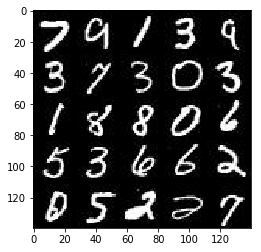

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

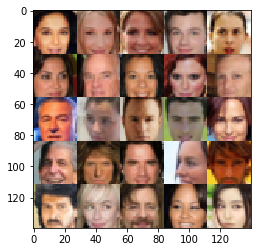

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    n_units = 4 * 4 * 256
    alpha = 0.2
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    num_units = 7*7*512
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                           activation=None)
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real, labels = tf.ones_like(disc_output_real) * (1 - smooth) )
    )
    
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.zeros_like(disc_output_fake) )
    )
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.ones_like(disc_output_fake) )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate} )
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate} )
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses               
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


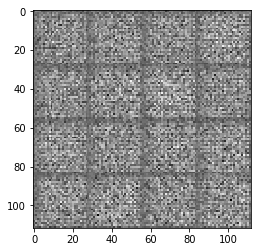

Epoch 1/2... Discriminator Loss: 0.4625... Generator Loss: 2.6972
Epoch 1/2... Discriminator Loss: 0.5628... Generator Loss: 4.9113
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 5.9196
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 6.6628
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 6.8136
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 5.0630
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 6.7514
Epoch 1/2... Discriminator Loss: 0.3412... Generator Loss: 6.3429
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 6.1921
Epoch 1/2... Discriminator Loss: 0.3477... Generator Loss: 6.2098


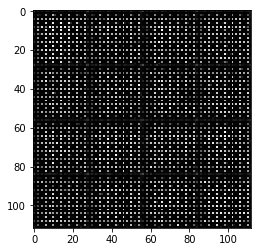

Epoch 1/2... Discriminator Loss: 0.3425... Generator Loss: 6.9350
Epoch 1/2... Discriminator Loss: 0.3388... Generator Loss: 7.1803
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 6.6847
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 6.6719
Epoch 1/2... Discriminator Loss: 0.3353... Generator Loss: 6.9157
Epoch 1/2... Discriminator Loss: 0.3697... Generator Loss: 6.4462
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 10.0664
Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 4.8939
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 5.5888
Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 5.4949


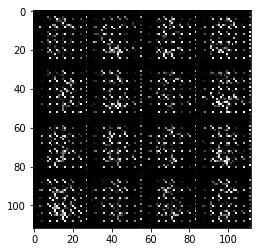

Epoch 1/2... Discriminator Loss: 2.5481... Generator Loss: 0.2903
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 2.5400
Epoch 1/2... Discriminator Loss: 0.7365... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 2.3153
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 3.0276
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.7187
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 3.1493


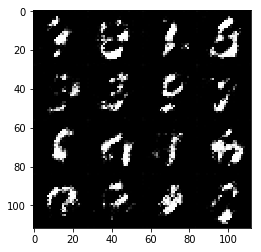

Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.7441
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.7362
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.3656
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 1.8678
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.7071


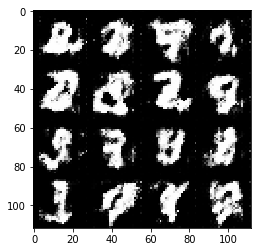

Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 2.2803
Epoch 1/2... Discriminator Loss: 0.6891... Generator Loss: 1.8735
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.5547
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.1461
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 1.0339
Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 1.7669
Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 2.7985
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 2.0904
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 3.5563
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.9535


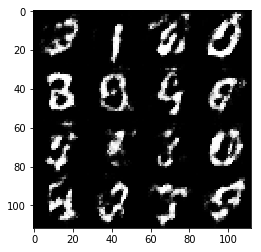

Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 2.7182
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.5945
Epoch 1/2... Discriminator Loss: 0.8651... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.2369
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 2.8028
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 2.7695
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 1.2955
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 2.4521


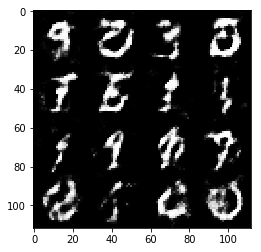

Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 3.5591
Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 2.0510
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 2.7899
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.6623
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.6391
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 2.4347
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.7431
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 1.0185
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 2.1919


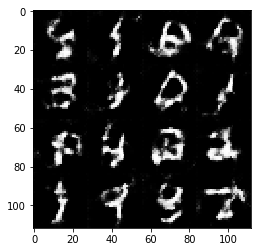

Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.1116
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 0.9576... Generator Loss: 2.1538
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.3300
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.8957
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.8376


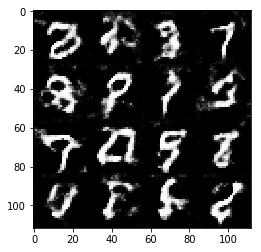

Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 2.9508
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.5715
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 2.5517
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 2.0788
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.3158
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 1.3379
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 0.9093... Generator Loss: 2.0372
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.4447
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.7626


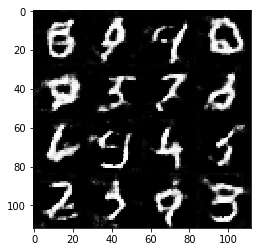

Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 2.0274
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.7253
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 0.7853... Generator Loss: 1.4274
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 1.6594
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.8188
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.3373


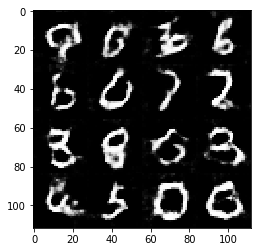

Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 2.2247
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 1.2146
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.7147
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 1.1977
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.5424


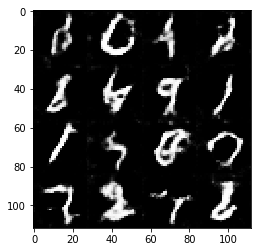

Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.2827
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 1.8205
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.7063
Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 1.3514
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.9866
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.7356
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 2.3762
Epoch 2/2... Discriminator Loss: 0.9401... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 0.7571... Generator Loss: 1.7234


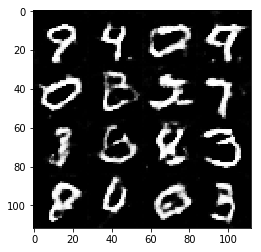

Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 2.4572
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 1.2130
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.4263
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 2.6904
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.9703
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 2.4148
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.8722
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.8894
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.6731


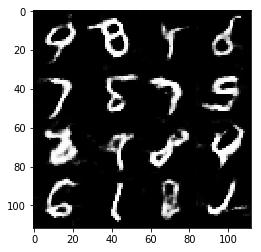

Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.8419
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0510
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.6227
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.9228
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.8693
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.0740
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 1.7614
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 2.8662
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 2.0106
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 2.0004


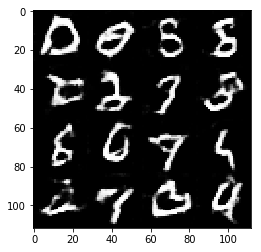

Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 1.4675
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.3670
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.6549
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.8657
Epoch 2/2... Discriminator Loss: 0.6845... Generator Loss: 1.5636
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 2.0018
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.1663


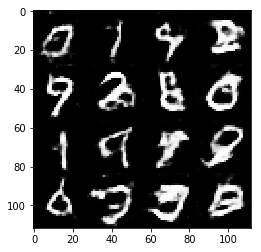

Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.3924
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.5453
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.6150
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.2809
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.2224
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 2.5347
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 1.5711
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 2.1089
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.8475


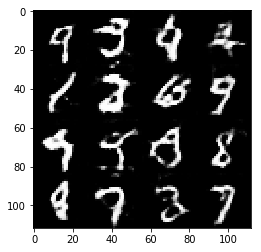

Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.9875
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 2.0748
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.2852
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.9340
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.5855
Epoch 2/2... Discriminator Loss: 0.8397... Generator Loss: 2.5611
Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 1.3177
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.9073


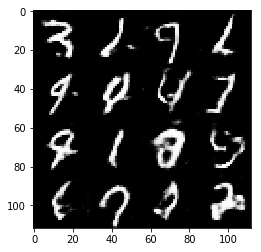

Epoch 2/2... Discriminator Loss: 0.6641... Generator Loss: 1.6625
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 2.1752
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.8113
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.3543
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.6787
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 2.1538
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.6226
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.3947
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.0080


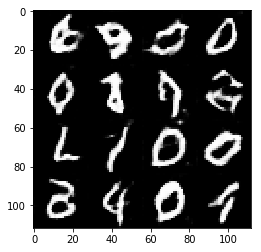

Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 1.5721
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.0998
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 2.2067
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.3812


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


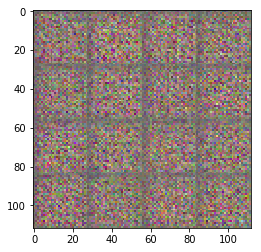

Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.6297
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.8207
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 4.4136
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.5840
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.5263
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.7546
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 3.2111
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 5.0894


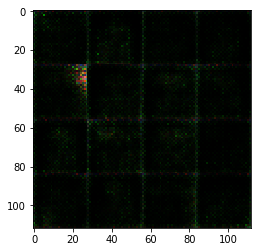

Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 6.2394
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.8702
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 4.0525
Epoch 1/1... Discriminator Loss: 0.4514... Generator Loss: 3.2101
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.6823
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 7.1163
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 2.7306
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 3.2559
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 3.9049
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.0128


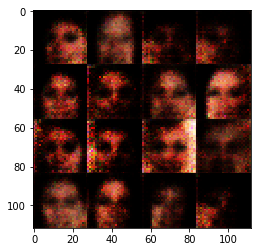

Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 2.0878
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.2447
Epoch 1/1... Discriminator Loss: 2.2532... Generator Loss: 0.2565
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 2.7468
Epoch 1/1... Discriminator Loss: 2.7658... Generator Loss: 4.8240
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.9276... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 3.7107
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.4682


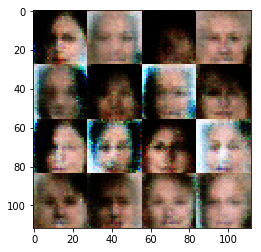

Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.4483
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 2.8254
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.7677
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8679


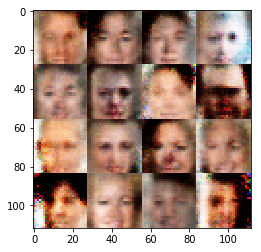

Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.6058
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 2.2083
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.2246


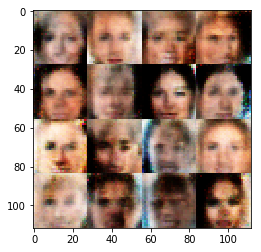

Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 2.0439
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.9423
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.4261
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 2.9475


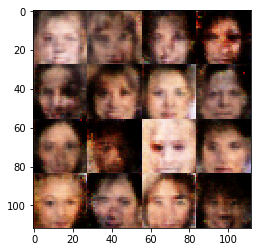

Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 2.1471
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.4731
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 2.9752
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.9895
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 2.0387


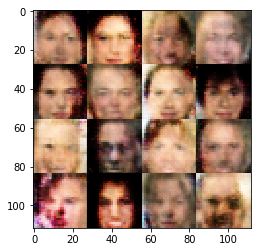

Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.7393... Generator Loss: 2.2799
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 2.1236


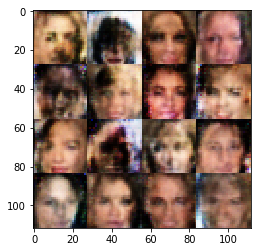

Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.7542... Generator Loss: 2.5498
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.6415
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 1.8631
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 2.2333
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8764


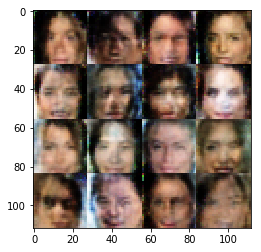

Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.9223


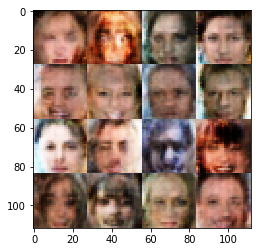

Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.5147
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.3959


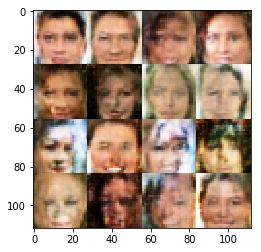

Epoch 1/1... Discriminator Loss: 1.7636... Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.4733
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9375


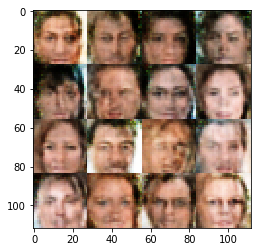

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.1302


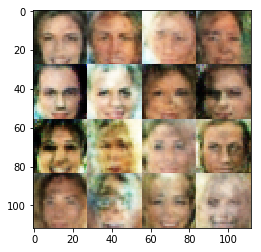

Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.5241
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.3193
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.5065


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.